# Weekly task 2 - Dicky Adi

## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

## Read and basic knowledge of the dataset

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
cols = df.columns.to_list()

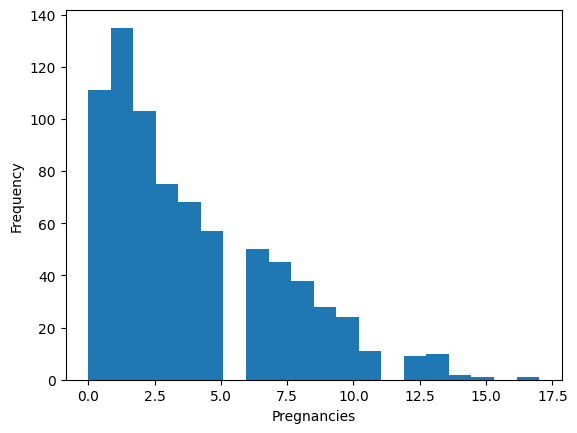

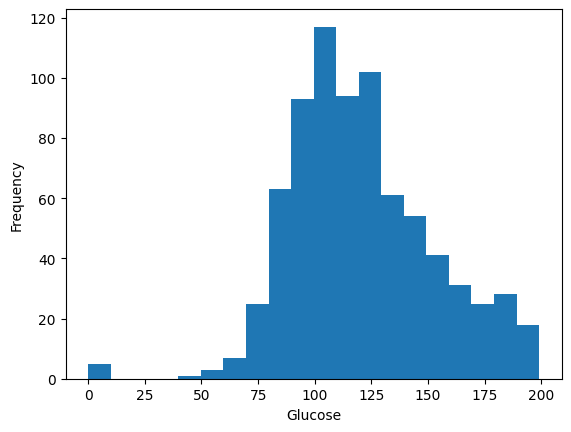

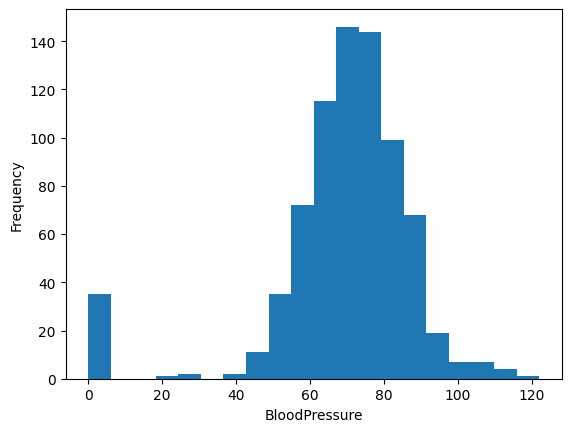

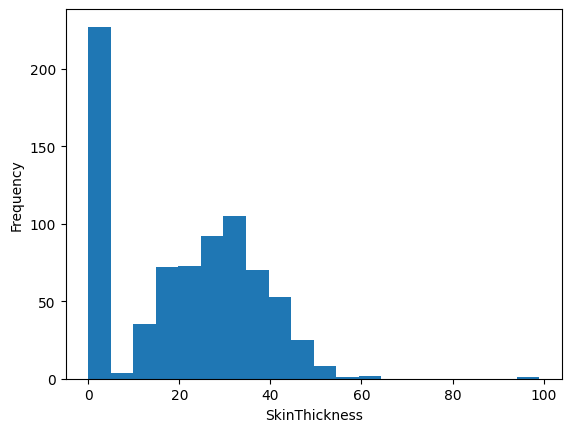

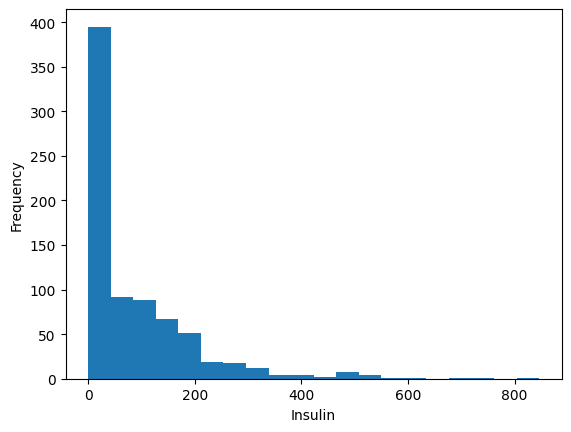

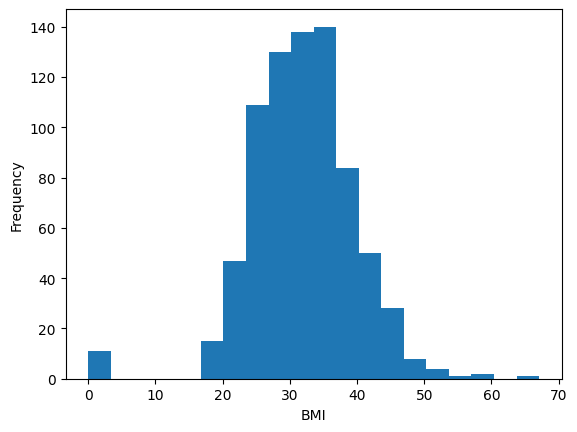

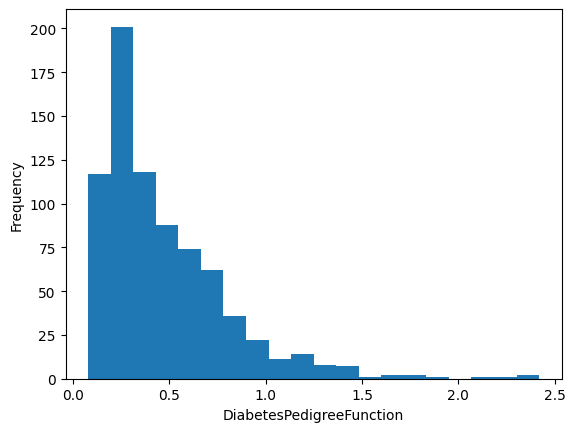

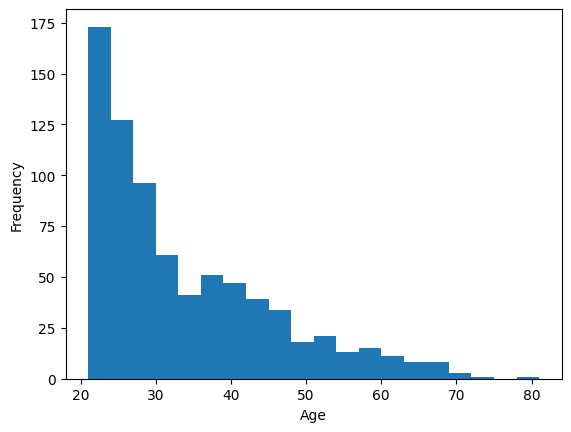

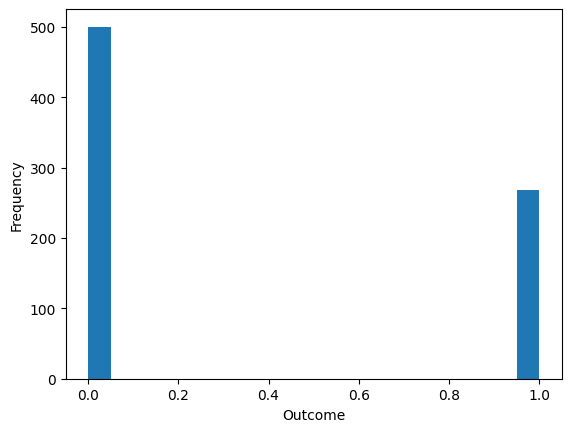

In [7]:
for col in cols:
    plt.hist(df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## Outliers handling

Based on above histogram visualization, seems like there're some outliers. However, to be precise lets check the boxplot visualization

<function matplotlib.pyplot.show(close=None, block=None)>

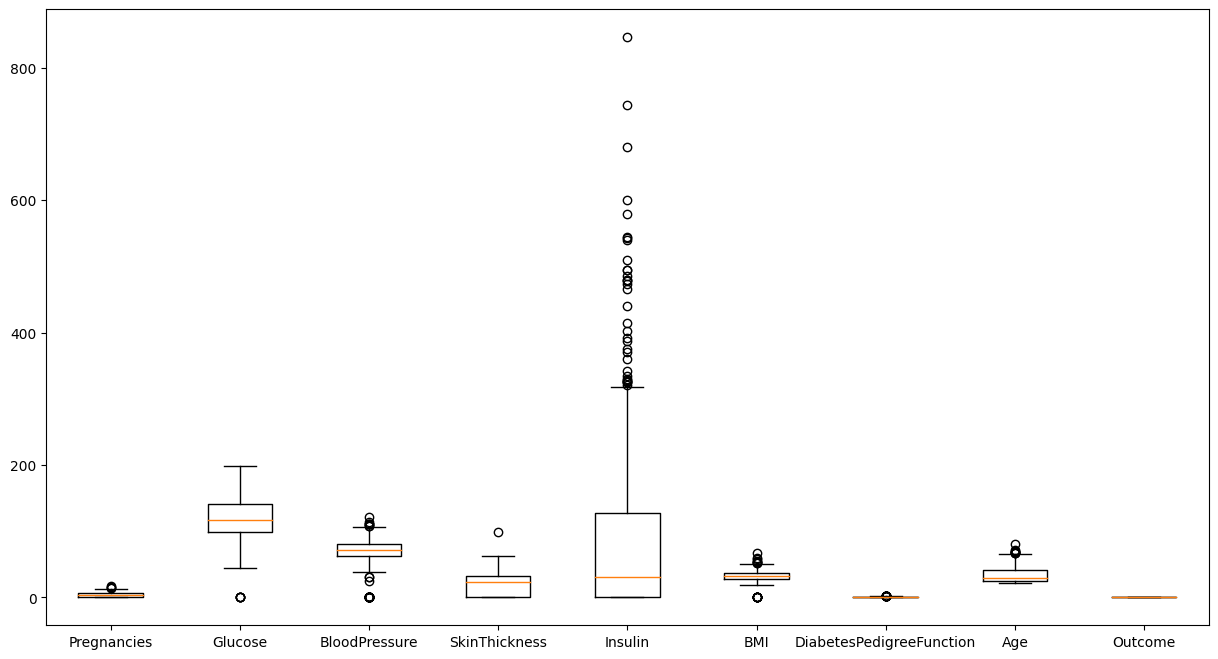

In [8]:
plt.figure(figsize=(15,8))
plt.boxplot(df.values)
plt.xticks(range(1, len(df.columns) + 1), df.columns)
plt.show

Based on boxplot visualization above, there're a lot of outliers. Therefore we need to handle these outliers carefully by logging the outliers, but before we do that let's get the outliers value

In [9]:
threshold = 2
multiplier = 1.5

dfOutliers = df.copy(deep=True)
# colsOut = df.drop(['Age', 'Outcome'], axis=1).columns.to_list()

for col in dfOutliers.drop(['Age', 'Outcome'], axis=1).columns.to_list():
    # mean = df[col].mean()
    # std = df[col].std()
    # outliers = df[col][(df[col] - mean).abs() > threshold * std]
    # dfOutliers.loc[outliers.index, col] = np.log(outliers)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # outliers = df[col][(df[col] < Q1 - multiplier * IQR) | (df[col] > Q3 + multiplier * IQR)]
    # outliers = df[column][(df[column] < Q1 - multiplier * IQR) | (df[column] > Q3 + multiplier * IQR)]
    outliers = df[col][(df[col] < Q1 - multiplier * IQR) | (df[col] > Q3 + multiplier * IQR)]
    if outliers.dtype == 'int64':
        dfOutliers.loc[outliers.index, col] = round(np.log(outliers + 1e-10))
    else:
        dfOutliers.loc[outliers.index, col] = np.log(outliers + 1e-10)

dfOutliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627000,50,1
1,1,85,66,29,0,26.6,0.351000,31,0
2,8,183,64,0,0,23.3,0.672000,32,1
3,1,89,66,23,94,28.1,0.167000,21,0
4,0,137,40,35,168,43.1,0.827678,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171000,63,0
764,2,122,70,27,0,36.8,0.340000,27,0
765,5,121,72,23,112,26.2,0.245000,30,0
766,1,126,60,0,0,30.1,0.349000,47,1


## EDA

In [10]:
dfOutliers.groupby('Outcome').count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268


Based on table above, seems like we're having an imbalance dataset

In [11]:
dfOutliers.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.842000,66.564000,19.664000,55.754000,29.686545,0.402329,31.190000
1,4.686567,141.085821,67.776119,21.813433,67.458955,33.792707,0.479117,37.067164


Based on the table above, seems like the the predicted diabetic has higher mean in almost all columns

<AxesSubplot: >

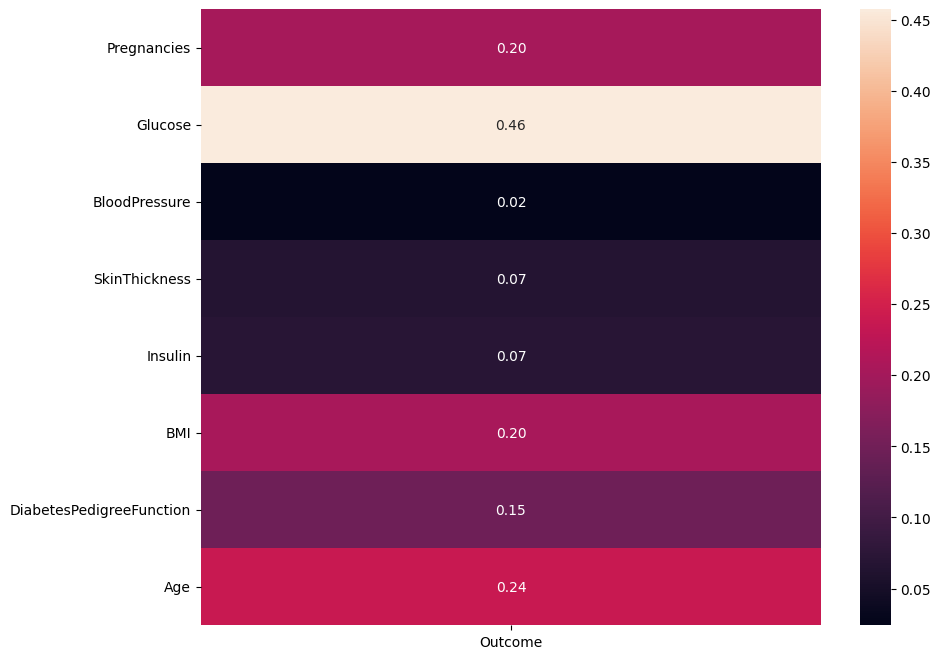

In [12]:
target = 'Outcome'
corr = dfOutliers.corr()[target]
corr = corr.drop(target)
dfCorr = pd.DataFrame(corr)
plt.figure(figsize=(10,8))
sns.heatmap(dfCorr, annot=True, fmt='.2f')

In [13]:
highCorr = dfCorr[abs(dfCorr) >= 0.2].dropna().index

In [14]:
print(highCorr)

Index(['Pregnancies', 'Glucose', 'BMI', 'Age'], dtype='object')


In [15]:
allCols = dfOutliers.copy(deep=True)
highCols = pd.concat([dfOutliers[highCorr], dfOutliers['Outcome']], axis=1)

In [16]:
scaler = MinMaxScaler()
allColsVal = scaler.fit_transform(allCols)
allColsDf = pd.DataFrame(allColsVal, columns=allCols.columns.to_list())
allColsDf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.461538,0.770270,0.736434,0.555556,0.000000,0.775422,0.493261,0.483333,1.0
1,0.076923,0.486486,0.689922,0.460317,0.000000,0.679566,0.245283,0.166667,0.0
2,0.615385,0.927928,0.674419,0.000000,0.000000,0.634376,0.533693,0.183333,1.0
3,0.076923,0.504505,0.689922,0.365079,0.295597,0.700106,0.079964,0.000000,0.0
4,0.000000,0.720721,0.488372,0.555556,0.528302,0.905513,0.673565,0.200000,1.0
...,...,...,...,...,...,...,...,...,...
763,0.769231,0.558559,0.767442,0.761905,0.566038,0.765836,0.083558,0.700000,0.0
764,0.153846,0.653153,0.720930,0.428571,0.000000,0.819242,0.235400,0.100000,0.0
765,0.384615,0.648649,0.736434,0.365079,0.352201,0.674088,0.150045,0.150000,0.0
766,0.076923,0.671171,0.643411,0.000000,0.000000,0.727494,0.243486,0.433333,1.0


In [17]:
scaler2 = MinMaxScaler()
highColsVal = scaler2.fit_transform(highCols)
highColsDf = pd.DataFrame(highColsVal, columns=highCols.columns.to_list())
highColsDf

,Pregnancies,Glucose,BMI,Age,Outcome
0,0.461538,0.770270,0.775422,0.483333,1.0
1,0.076923,0.486486,0.679566,0.166667,0.0
2,0.615385,0.927928,0.634376,0.183333,1.0
3,0.076923,0.504505,0.700106,0.000000,0.0
4,0.000000,0.720721,0.905513,0.200000,1.0
...,...,...,...,...,...
763,0.769231,0.558559,0.765836,0.700000,0.0
764,0.153846,0.653153,0.819242,0.100000,0.0
765,0.384615,0.648649,0.674088,0.150000,0.0
766,0.076923,0.671171,0.727494,0.433333,1.0


## Modelling

Since we're using pytorch to develop the deep learning model, lets create the custom dataset first then the dataloader

In [143]:
# yHighCols = torch.tensor(highColsDf[target].values, dtype=torch.float32)
# yAllCols = torch.tensor(allColsDf[target].values, dtype=torch.float32)
# bc = np.bincount(yHighCols)
# bcAll = np.bincount(yAllCols)
# cwHigh = torch.tensor([768 / (2 * bc[0]), 768 / (2 * bc[1])])
# cwAll = torch.tensor([768 / (2 * bcAll[0]), 768 / (2 * bcAll[1])])
# print(cwHigh)
# print(cwAll)

# import pandas as pd
# import torch

# Assuming your DataFrame is named df and the column of interest is 'column_name'
# column_values = highColsDf[target].values.astype(int)
# class_counts = torch.bincount(torch.from_numpy(column_values))
# total_samples = len(column_values)
# class_weights = total_samples / (len(class_counts) * class_counts.float())

# print(class_weights)

def getClassWeight(loader):
    classWeights = []
    for features, targets in loader:
        target = targets.to(torch.int32)
        classCount = torch.bincount(target)
        totalSamples = len(target)
        cwVal = totalSamples / (len(classCount) * classCount.float())
        cwValItem = [x.item() for x in cwVal]
        classWeights.append(cwValItem)
    # classWeights = torch.cat(classWeights)
    return torch.tensor(classWeights)

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [20]:
classNames = ['Non-diabetic', 'Diabetic']
lr = 0.01
epochs = 250

In [21]:
class customDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset.drop(target, axis=1).values
        self.target = dataset[target].values
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        inputs = torch.tensor(self.data[index], dtype=torch.float32)
        targets = torch.tensor(self.target[index], dtype=torch.float32)
        return inputs, targets

dataNormal = customDataset(allColsDf)
dataHigh = customDataset(highColsDf)

In [22]:
trainRatio = .8
valRatio = .2
batchSize = 32

trainSizeNormal = int(len(dataNormal) * trainRatio)
valSizeNormal = len(dataNormal) - trainSizeNormal

trainSizeHigh = int(len(dataHigh) * trainRatio)
valSizeHigh = len(dataHigh) - trainSizeHigh

trainSetNormal, valSetNormal = random_split(dataNormal, [trainSizeNormal, valSizeNormal])
trainSetHigh, valSetHigh = random_split(dataHigh, [trainSizeHigh, valSizeHigh])

inFeatureNormal = allCols.drop(target, axis=1).shape[1]
inFeatureHigh = highCols.drop(target, axis=1).shape[1]

sizeNormal = {
    'train' : len(trainSetNormal),
    'val' : len(valSetNormal)
}

sizeHigh = {
    'train' : len(trainSetHigh),
    'val' : len(valSetHigh)
}

# BECAREFUL WHEN DEFINING THE NUM_WORKERS AND PIN_MEMORY PARAMETER IN DATALOADER, BECAUSE IT WILL RUIN THE PERFORMANCES OF YOUR GPU AND CPU IF YOU DONT HAVE HIGH SPECS
loaderNormal = {
    'train' : DataLoader(trainSetNormal, batch_size=batchSize, shuffle=True, num_workers=8, pin_memory=True),
    'val' : DataLoader(valSetNormal, batch_size=batchSize, shuffle=False, num_workers=8, pin_memory=True)
}
loaderHigh = {
    'train' : DataLoader(trainSetHigh, batch_size=batchSize, shuffle=True, num_workers=8, pin_memory=True),
    'val' : DataLoader(valSetHigh, batch_size=batchSize, shuffle=False, num_workers=8, pin_memory=True)
}

In [144]:
cwNormal = getClassWeight(loaderNormal['train'])
cwHigh = getClassWeight(loaderHigh['train'])

In [145]:
# cwNormal = np.array(cwHigh)
print(cwNormal.shape)
print(cwNormal)

torch.Size([1228])
tensor([0.6957, 1.7778, 0.6957,  ..., 1.5000, 0.7500, 1.5000])


In [151]:
def trainingFunction(model, epochs, loader, size, criterion, optimizer, patience=5, device=device):
    trainAccLog = []
    trainLossLog = []
    validationAccLog = []
    validationLossLog = []
    epochLog = []
    model.to(device)
    # criterion.to(device)
    earlyStop = 0
    bestLoss = float('inf')

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*10)
        epochLog.append(epoch)
        for phase in ['train', 'val']:
            if phase=='train':
                model.train()
            else:
                model.eval()
            runningLoss = .0
            runningAcc = .0
            for features, targets in tqdm(loader[phase], desc='Batch', leave=False):
                feature = features.to(device)
                target = targets.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(feature)
                    _, pred = torch.max(outputs, 1)
                    # print(outputs.squeeze().shape)
                    print(target.shape)
                    print(outputs.shape)
                    loss = criterion(outputs.squeeze(), target)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                runningLoss += loss.item() * features.size(0)
                runningAcc += torch.sum(pred == target)
                del feature, target, outputs, _, pred
                torch.cuda.empty_cache()
            epochLoss = runningLoss / size[phase]
            epochAcc = runningAcc.double() / size[phase]
            if phase == 'train':
                trainAccLog.append(epochAcc)
                trainLossLog.append(epochLoss)
            elif phase == 'val':
                validationAccLog.append(epochAcc)
                validationLossLog.append(epochLoss)
                if patience:
                    if epochLoss < bestLoss:
                        bestLoss = epochLoss
                        earlyStop = 0
                    else:
                        earlyStop += 1
            tqdm.write(f'{phase} phase Accuracy : {epochAcc:.4f} and Loss : {epochLoss:.4f}')

        if earlyStop >= patience:
            tqdm.write(f'Early stopping, no improvement in {patience} epochs')
            break
        print()
    tqdm.write('Training Finished')
    return (model, epochLog, trainAccLog, trainLossLog, validationAccLog, validationLossLog)

In [137]:
def visLog(epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle):
    fig, ax = plt.subplots(nrows=2, figsize=(10,8))
    trainAcc = [x.cpu() for x in trainAcc]
    validationAcc = [x.cpu() for x in validationAcc]
    
    ax[0].plot(epochLog, trainLoss, label='Training Loss')
    ax[0].plot(epochLog, validationLoss, label='Validation Loss')
    ax[0].set(xlabel="Epoch", ylabel="Loss", title="Train & Validation Loss")
    
    ax[1].plot(epochLog, trainAcc, label='Training Accuracy')
    ax[1].plot(epochLog, validationAcc, label='Validation Accuracy')
    ax[1].set(xlabel="Epoch", ylabel="Accuracy", title="Train & Validation Accuracy")

    ax[0].legend()
    ax[1].legend()
    plt.suptitle(supTitle)
    fig.tight_layout(pad=2.0)
    plt.show()

In [138]:
def evalFunction(model, loader, epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle, device=device):
    plt.figure(figsize=(10,8))
    total = 0
    correct = 0
    pred = []
    truth = []

    with torch.no_grad():
        model.eval()
        for i, (features, targets) in enumerate(loader['val']):
            feature = features.to(device)
            target = targets.to(device)

            outputs = model(feature)
            _, preds = torch.max(outputs, 1)

            pred.extend(preds.data.cpu().numpy())
            truth.extend(target.data.cpu().numpy())

            total+=target.size(0)
            correct+=(preds==target).sum().item()
        
        visLog(epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle)

        print(classification_report(truth, pred, target_names=classNames))
        print(f'accuracy on the model was {100 * correct / total}%')
        cfMatrix = confusion_matrix(truth, pred)
        df = pd.DataFrame(cfMatrix, index=[i for i in classNames], columns=[i for i in classNames])
        sns.heatmap(df, annot=True, fmt='.2f')


### Model for all columns

List of model:
- model1 : deep and wide
- model2 : deep and shallow
- model3 : narrow and wide
- model4 : narrow and shallow

In [139]:
class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=256, out_features=128)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=128, out_features=64)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=64, out_features=32)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=32, out_features=1)
    def forward(self,x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return x
model1 = model1()
summary(model1, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model1                                   [1, 1, 1]                 --
├─Linear: 1-1                            [1, 1, 512]               4,608
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 128]               32,896
├─ReLU: 1-6                              [1, 1, 128]               --
├─Linear: 1-7                            [1, 1, 64]                8,256
├─ReLU: 1-8                              [1, 1, 64]                --
├─Linear: 1-9                            [1, 1, 32]                2,080
├─ReLU: 1-10                             [1, 1, 32]                --
├─Linear: 1-11                           [1, 1, 1]                 33
Total params: 179,201
Trainable params: 179,201
Non-trainable param

In [27]:
class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=128)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=128, out_features=64)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=64, out_features=32)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=32, out_features=16)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=16, out_features=8)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=1)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return x
model2 = model2()
summary(model2, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model2                                   [1, 1, 1]                 --
├─Linear: 1-1                            [1, 1, 128]               1,152
├─ReLU: 1-2                              [1, 1, 128]               --
├─Linear: 1-3                            [1, 1, 64]                8,256
├─ReLU: 1-4                              [1, 1, 64]                --
├─Linear: 1-5                            [1, 1, 32]                2,080
├─ReLU: 1-6                              [1, 1, 32]                --
├─Linear: 1-7                            [1, 1, 16]                528
├─ReLU: 1-8                              [1, 1, 16]                --
├─Linear: 1-9                            [1, 1, 8]                 136
├─ReLU: 1-10                             [1, 1, 8]                 --
├─Linear: 1-11                           [1, 1, 1]                 9
Total params: 12,161
Trainable params: 12,161
Non-trainable params: 0
Total

In [28]:
class model3(nn.Module):
    def __init__(self):
        super(model3, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=256, out_features=1)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return x
model3 = model3()
summary(model3, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model3                                   [1, 1, 1]                 --
├─Linear: 1-1                            [1, 1, 512]               4,608
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 1]                 257
Total params: 136,193
Trainable params: 136,193
Non-trainable params: 0
Total mult-adds (M): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.54
Estimated Total Size (MB): 0.55

In [29]:
class model4(nn.Module):
    def __init__(self):
        super(model4, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=16)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=16, out_features=8)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=1)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return x
model4 = model4()
summary(model4, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model4                                   [1, 1, 1]                 --
├─Linear: 1-1                            [1, 1, 16]                144
├─ReLU: 1-2                              [1, 1, 16]                --
├─Linear: 1-3                            [1, 1, 8]                 136
├─ReLU: 1-4                              [1, 1, 8]                 --
├─Linear: 1-5                            [1, 1, 1]                 9
Total params: 289
Trainable params: 289
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Model for high corr cols

List of the model still the same with the model above

In [30]:
class model1high(nn.Module):
    def __init__(self):
        super(model1high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=256, out_features=128)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=128, out_features=64)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=64, out_features=32)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=32, out_features=1)
    def forward(self,x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return x
model1high = model1high()
summary(model1high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model1high                               [1, 1, 1]                 --
├─Linear: 1-1                            [1, 1, 512]               2,560
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 128]               32,896
├─ReLU: 1-6                              [1, 1, 128]               --
├─Linear: 1-7                            [1, 1, 64]                8,256
├─ReLU: 1-8                              [1, 1, 64]                --
├─Linear: 1-9                            [1, 1, 32]                2,080
├─ReLU: 1-10                             [1, 1, 32]                --
├─Linear: 1-11                           [1, 1, 1]                 33
Total params: 177,153
Trainable params: 177,153
Non-trainable param

In [31]:
class model2high(nn.Module):
    def __init__(self):
        super(model2high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=128)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=128, out_features=64)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=64, out_features=32)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=32, out_features=16)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=16, out_features=8)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=1)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return x
model2high = model2high()
summary(model2high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model2high                               [1, 1, 1]                 --
├─Linear: 1-1                            [1, 1, 128]               640
├─ReLU: 1-2                              [1, 1, 128]               --
├─Linear: 1-3                            [1, 1, 64]                8,256
├─ReLU: 1-4                              [1, 1, 64]                --
├─Linear: 1-5                            [1, 1, 32]                2,080
├─ReLU: 1-6                              [1, 1, 32]                --
├─Linear: 1-7                            [1, 1, 16]                528
├─ReLU: 1-8                              [1, 1, 16]                --
├─Linear: 1-9                            [1, 1, 8]                 136
├─ReLU: 1-10                             [1, 1, 8]                 --
├─Linear: 1-11                           [1, 1, 1]                 9
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
Total m

In [32]:
class model3high(nn.Module):
    def __init__(self):
        super(model3high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=256, out_features=1)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return x
model3high = model3high()
summary(model3high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model3high                               [1, 1, 1]                 --
├─Linear: 1-1                            [1, 1, 512]               2,560
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 1]                 257
Total params: 134,145
Trainable params: 134,145
Non-trainable params: 0
Total mult-adds (M): 0.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.54
Estimated Total Size (MB): 0.54

In [33]:
class model4high(nn.Module):
    def __init__(self):
        super(model4high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=16)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=16, out_features=8)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=1)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return x
model4high = model4high()
summary(model4high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model4high                               [1, 1, 1]                 --
├─Linear: 1-1                            [1, 1, 16]                80
├─ReLU: 1-2                              [1, 1, 16]                --
├─Linear: 1-3                            [1, 1, 8]                 136
├─ReLU: 1-4                              [1, 1, 8]                 --
├─Linear: 1-5                            [1, 1, 1]                 9
Total params: 225
Trainable params: 225
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Training all cols

We're using Adam optimizer with the learning rate of 0.01 and no regularization to get to know about the regularization effect in deep learning

In [152]:
#model1
criterion1 = nn.BCEWithLogitsLoss(weight=cwNormal)
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
trainedModel1, epochLog1, trainAccLog1, trainLossLog1, validationAccLog1, validationLossLog1 = trainingFunction(model1, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion1, optimizer=optimizer1)

Epoch 1/250
----------


torch.Size([32])
torch.Size([32, 1])


RuntimeError: The size of tensor a (32) must match the size of tensor b (1228) at non-singleton dimension 0

In [34]:
#model2
criterion2 = nn.BCEWithLogitsLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=lr)
trainedModel2, epochLog2, trainAccLog2, trainLossLog2, validationAccLog2, validationLossLog2 = trainingFunction(model2, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion2, optimizer=optimizer2)

Epoch 1/250
----------


train phase Accuracy : 0.6498 and Loss : 0.6497


val phase Accuracy : 0.6558 and Loss : 0.6398

Epoch 2/250
----------


train phase Accuracy : 0.6498 and Loss : 0.6346


val phase Accuracy : 0.6558 and Loss : 0.6004

Epoch 3/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5850


val phase Accuracy : 0.6558 and Loss : 0.5453

Epoch 4/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5521


val phase Accuracy : 0.6558 and Loss : 0.5407

Epoch 5/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5382


val phase Accuracy : 0.6558 and Loss : 0.5111

Epoch 6/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5298


val phase Accuracy : 0.6558 and Loss : 0.4948

Epoch 7/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5142


val phase Accuracy : 0.6558 and Loss : 0.5141

Epoch 8/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5189


val phase Accuracy : 0.6558 and Loss : 0.4975

Epoch 9/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5438


val phase Accuracy : 0.6558 and Loss : 0.5375

Epoch 10/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5105


val phase Accuracy : 0.6558 and Loss : 0.5170

Epoch 11/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4907


val phase Accuracy : 0.6558 and Loss : 0.5117
Early stopping, no improvement in 5 epochs
Training Finished


In [35]:
#model3
criterion3 = nn.BCEWithLogitsLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=lr)
trainedModel3, epochLog3, trainAccLog3, trainLossLog3, validationAccLog3, validationLossLog3 = trainingFunction(model3, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion3, optimizer=optimizer3)

Epoch 1/250
----------


train phase Accuracy : 0.6498 and Loss : 0.6049


val phase Accuracy : 0.6558 and Loss : 0.4998

Epoch 2/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5210


val phase Accuracy : 0.6558 and Loss : 0.6029

Epoch 3/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5384


val phase Accuracy : 0.6558 and Loss : 0.4993

Epoch 4/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5078


val phase Accuracy : 0.6558 and Loss : 0.5223

Epoch 5/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4804


val phase Accuracy : 0.6558 and Loss : 0.5384

Epoch 6/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5114


val phase Accuracy : 0.6558 and Loss : 0.5026

Epoch 7/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4666


val phase Accuracy : 0.6558 and Loss : 0.5360

Epoch 8/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4530


val phase Accuracy : 0.6558 and Loss : 0.5833
Early stopping, no improvement in 5 epochs
Training Finished


In [36]:
#model4
criterion4 = nn.BCEWithLogitsLoss()
optimizer4 = optim.Adam(model4.parameters(), lr=lr)
trainedModel4, epochLog4, trainAccLog4, trainLossLog4, validationAccLog4, validationLossLog4 = trainingFunction(model4, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion4, optimizer=optimizer4)

Epoch 1/250
----------


train phase Accuracy : 0.6498 and Loss : 0.6821


val phase Accuracy : 0.6558 and Loss : 0.6480

Epoch 2/250
----------


train phase Accuracy : 0.6498 and Loss : 0.6476


val phase Accuracy : 0.6558 and Loss : 0.6282

Epoch 3/250
----------


train phase Accuracy : 0.6498 and Loss : 0.6369


val phase Accuracy : 0.6558 and Loss : 0.6074

Epoch 4/250
----------


train phase Accuracy : 0.6498 and Loss : 0.6100


val phase Accuracy : 0.6558 and Loss : 0.5835

Epoch 5/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5928


val phase Accuracy : 0.6558 and Loss : 0.5759

Epoch 6/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5803


val phase Accuracy : 0.6558 and Loss : 0.5488

Epoch 7/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5651


val phase Accuracy : 0.6558 and Loss : 0.5417

Epoch 8/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5612


val phase Accuracy : 0.6558 and Loss : 0.5348

Epoch 9/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5497


val phase Accuracy : 0.6558 and Loss : 0.5287

Epoch 10/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5421


val phase Accuracy : 0.6558 and Loss : 0.5313

Epoch 11/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5339


val phase Accuracy : 0.6558 and Loss : 0.5224

Epoch 12/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5297


val phase Accuracy : 0.6558 and Loss : 0.5240

Epoch 13/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5364


val phase Accuracy : 0.6558 and Loss : 0.5213

Epoch 14/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5257


val phase Accuracy : 0.6558 and Loss : 0.5181

Epoch 15/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5238


val phase Accuracy : 0.6558 and Loss : 0.5215

Epoch 16/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5206


val phase Accuracy : 0.6558 and Loss : 0.5084

Epoch 17/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5121


val phase Accuracy : 0.6558 and Loss : 0.5195

Epoch 18/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5134


val phase Accuracy : 0.6558 and Loss : 0.5096

Epoch 19/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5052


val phase Accuracy : 0.6558 and Loss : 0.5118

Epoch 20/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5196


val phase Accuracy : 0.6558 and Loss : 0.5450

Epoch 21/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5098


val phase Accuracy : 0.6558 and Loss : 0.4999

Epoch 22/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5003


val phase Accuracy : 0.6558 and Loss : 0.4968

Epoch 23/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4958


val phase Accuracy : 0.6558 and Loss : 0.4988

Epoch 24/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5110


val phase Accuracy : 0.6558 and Loss : 0.4980

Epoch 25/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4921


val phase Accuracy : 0.6558 and Loss : 0.4971

Epoch 26/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4866


val phase Accuracy : 0.6558 and Loss : 0.5037

Epoch 27/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4841


val phase Accuracy : 0.6558 and Loss : 0.4934

Epoch 28/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4846


val phase Accuracy : 0.6558 and Loss : 0.4862

Epoch 29/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4790


val phase Accuracy : 0.6558 and Loss : 0.4929

Epoch 30/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4883


val phase Accuracy : 0.6558 and Loss : 0.4970

Epoch 31/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4859


val phase Accuracy : 0.6558 and Loss : 0.4883

Epoch 32/250
----------


train phase Accuracy : 0.6498 and Loss : 0.5420


val phase Accuracy : 0.6558 and Loss : 0.4898

Epoch 33/250
----------


train phase Accuracy : 0.6498 and Loss : 0.4899


val phase Accuracy : 0.6558 and Loss : 0.5124
Early stopping, no improvement in 5 epochs
Training Finished


## Training high corr cols

In [37]:
#model1
criterion1high = nn.BCEWithLogitsLoss()
optimizer1high = optim.Adam(model1high.parameters(), lr=lr)
highTrainedModel1, highEpochLog1, highTrainAccLog1, highTrainLossLog1, highValidationAccLog1, highValidationLossLog1 = trainingFunction(model1high, epochs, loaderHigh, sizeHigh, criterion1high, optimizer1high)

Epoch 1/250
----------


train phase Accuracy : 0.6515 and Loss : 0.6902


val phase Accuracy : 0.6494 and Loss : 0.6287

Epoch 2/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5626


val phase Accuracy : 0.6494 and Loss : 0.8184

Epoch 3/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5658


val phase Accuracy : 0.6494 and Loss : 0.5292

Epoch 4/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5205


val phase Accuracy : 0.6494 and Loss : 0.6466

Epoch 5/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5417


val phase Accuracy : 0.6494 and Loss : 0.5278

Epoch 6/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5322


val phase Accuracy : 0.6494 and Loss : 0.5391

Epoch 7/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4957


val phase Accuracy : 0.6494 and Loss : 0.5646

Epoch 8/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5242


val phase Accuracy : 0.6494 and Loss : 0.5346

Epoch 9/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4847


val phase Accuracy : 0.6494 and Loss : 0.5406

Epoch 10/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4938


val phase Accuracy : 0.6494 and Loss : 0.5771
Early stopping, no improvement in 5 epochs
Training Finished


In [38]:
#model2
criterion2high = nn.BCEWithLogitsLoss()
optimizer2high = optim.Adam(model2high.parameters(), lr=lr)
highTrainedModel2, highEpochLog2, highTrainAccLog2, highTrainLossLog2, highValidationAccLog2, highValidationLossLog2 = trainingFunction(model2high, epochs, loaderHigh, sizeHigh, criterion2high, optimizer2high)

Epoch 1/250
----------


train phase Accuracy : 0.6515 and Loss : 0.6628


val phase Accuracy : 0.6494 and Loss : 0.6462

Epoch 2/250
----------


train phase Accuracy : 0.6515 and Loss : 0.6161


val phase Accuracy : 0.6494 and Loss : 0.5853

Epoch 3/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5653


val phase Accuracy : 0.6494 and Loss : 0.5634

Epoch 4/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5315


val phase Accuracy : 0.6494 and Loss : 0.5520

Epoch 5/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5099


val phase Accuracy : 0.6494 and Loss : 0.5289

Epoch 6/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5368


val phase Accuracy : 0.6494 and Loss : 0.5599

Epoch 7/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5578


val phase Accuracy : 0.6494 and Loss : 0.5582

Epoch 8/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5164


val phase Accuracy : 0.6494 and Loss : 0.5420

Epoch 9/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5026


val phase Accuracy : 0.6494 and Loss : 0.5379

Epoch 10/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5035


val phase Accuracy : 0.6494 and Loss : 0.5383
Early stopping, no improvement in 5 epochs
Training Finished


In [39]:
#model3
criterion3high = nn.BCEWithLogitsLoss()
optimizer3high = optim.Adam(model3high.parameters(), lr=lr)
highTrainedModel3, highEpochLog3, highTrainAccLog3, highTrainLossLog3, highValidationAccLog3, highValidationLossLog3 = trainingFunction(model3high, epochs, loaderHigh, sizeHigh, criterion3high, optimizer3high)

Epoch 1/250
----------


train phase Accuracy : 0.6515 and Loss : 0.6718


val phase Accuracy : 0.6494 and Loss : 0.5739

Epoch 2/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5417


val phase Accuracy : 0.6494 and Loss : 0.5449

Epoch 3/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5111


val phase Accuracy : 0.6494 and Loss : 0.5475

Epoch 4/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5451


val phase Accuracy : 0.6494 and Loss : 0.5253

Epoch 5/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5030


val phase Accuracy : 0.6494 and Loss : 0.5203

Epoch 6/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4926


val phase Accuracy : 0.6494 and Loss : 0.5167

Epoch 7/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5001


val phase Accuracy : 0.6494 and Loss : 0.5635

Epoch 8/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5390


val phase Accuracy : 0.6494 and Loss : 0.5264

Epoch 9/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4715


val phase Accuracy : 0.6494 and Loss : 0.5224

Epoch 10/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4810


val phase Accuracy : 0.6494 and Loss : 0.5293

Epoch 11/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4809


val phase Accuracy : 0.6494 and Loss : 0.5162

Epoch 12/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4787


val phase Accuracy : 0.6494 and Loss : 0.5216

Epoch 13/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4614


val phase Accuracy : 0.6494 and Loss : 0.5170

Epoch 14/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4591


val phase Accuracy : 0.6494 and Loss : 0.5242

Epoch 15/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4558


val phase Accuracy : 0.6494 and Loss : 0.5293

Epoch 16/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4448


val phase Accuracy : 0.6494 and Loss : 0.5759
Early stopping, no improvement in 5 epochs
Training Finished


In [40]:
#model4
criterion4high = nn.BCEWithLogitsLoss()
optimizer4high = optim.Adam(model4high.parameters(), lr=lr)
highTrainedModel4, highEpochLog4, highTrainAccLog4, highTrainLossLog4, highValidationAccLog4, highValidationLossLog4 = trainingFunction(model4high, epochs, loaderHigh, sizeHigh, criterion4high, optimizer4high)

Epoch 1/250
----------


train phase Accuracy : 0.6515 and Loss : 0.6730


val phase Accuracy : 0.6494 and Loss : 0.6542

Epoch 2/250
----------


train phase Accuracy : 0.6515 and Loss : 0.6519


val phase Accuracy : 0.6494 and Loss : 0.6460

Epoch 3/250
----------


train phase Accuracy : 0.6515 and Loss : 0.6372


val phase Accuracy : 0.6494 and Loss : 0.6287

Epoch 4/250
----------


train phase Accuracy : 0.6515 and Loss : 0.6113


val phase Accuracy : 0.6494 and Loss : 0.6047

Epoch 5/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5848


val phase Accuracy : 0.6494 and Loss : 0.5910

Epoch 6/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5678


val phase Accuracy : 0.6494 and Loss : 0.5722

Epoch 7/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5444


val phase Accuracy : 0.6494 and Loss : 0.5498

Epoch 8/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5331


val phase Accuracy : 0.6494 and Loss : 0.5461

Epoch 9/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5199


val phase Accuracy : 0.6494 and Loss : 0.5502

Epoch 10/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5051


val phase Accuracy : 0.6494 and Loss : 0.5541

Epoch 11/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5013


val phase Accuracy : 0.6494 and Loss : 0.5338

Epoch 12/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4998


val phase Accuracy : 0.6494 and Loss : 0.5292

Epoch 13/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4899


val phase Accuracy : 0.6494 and Loss : 0.5657

Epoch 14/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5047


val phase Accuracy : 0.6494 and Loss : 0.5323

Epoch 15/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4859


val phase Accuracy : 0.6494 and Loss : 0.5275

Epoch 16/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5021


val phase Accuracy : 0.6494 and Loss : 0.5260

Epoch 17/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4828


val phase Accuracy : 0.6494 and Loss : 0.5257

Epoch 18/250
----------


train phase Accuracy : 0.6515 and Loss : 0.5018


val phase Accuracy : 0.6494 and Loss : 0.5451

Epoch 19/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4824


val phase Accuracy : 0.6494 and Loss : 0.5267

Epoch 20/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4895


val phase Accuracy : 0.6494 and Loss : 0.5409

Epoch 21/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4969


val phase Accuracy : 0.6494 and Loss : 0.5323

Epoch 22/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4936


val phase Accuracy : 0.6494 and Loss : 0.5207

Epoch 23/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4952


val phase Accuracy : 0.6494 and Loss : 0.5263

Epoch 24/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4744


val phase Accuracy : 0.6494 and Loss : 0.5196

Epoch 25/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4716


val phase Accuracy : 0.6494 and Loss : 0.5496

Epoch 26/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4912


val phase Accuracy : 0.6494 and Loss : 0.5201

Epoch 27/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4723


val phase Accuracy : 0.6494 and Loss : 0.5167

Epoch 28/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4715


val phase Accuracy : 0.6494 and Loss : 0.5251

Epoch 29/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4709


val phase Accuracy : 0.6494 and Loss : 0.5200

Epoch 30/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4721


val phase Accuracy : 0.6494 and Loss : 0.5191

Epoch 31/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4806


val phase Accuracy : 0.6494 and Loss : 0.5204

Epoch 32/250
----------


train phase Accuracy : 0.6515 and Loss : 0.4739


val phase Accuracy : 0.6494 and Loss : 0.5194
Early stopping, no improvement in 5 epochs
Training Finished


## Evaluation all cols

<Figure size 1000x800 with 0 Axes>

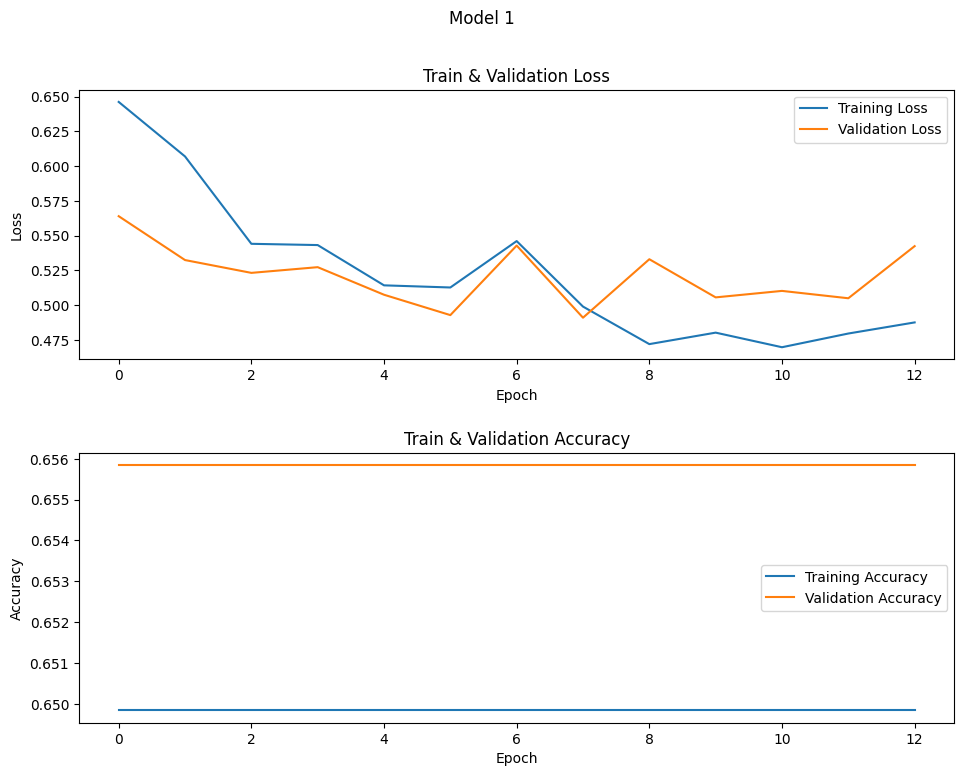

              precision    recall  f1-score   support

Non-diabetic       0.66      1.00      0.79       101
    Diabetic       0.00      0.00      0.00        53

    accuracy                           0.66       154
   macro avg       0.33      0.50      0.40       154
weighted avg       0.43      0.66      0.52       154

accuracy on the model was 65.58441558441558%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


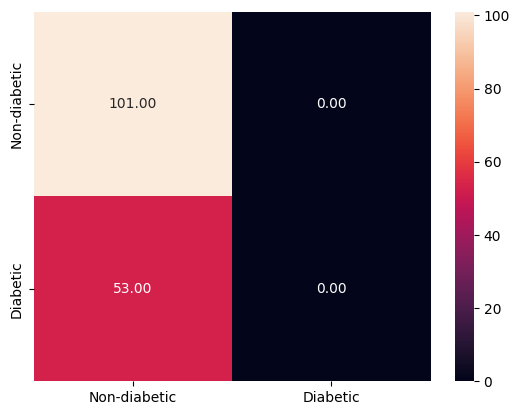

In [41]:
#model1
evalFunction(model1, loaderNormal, epochLog1, trainAccLog1, trainLossLog1, validationAccLog1, validationLossLog1, 'Model 1')

<Figure size 1000x800 with 0 Axes>

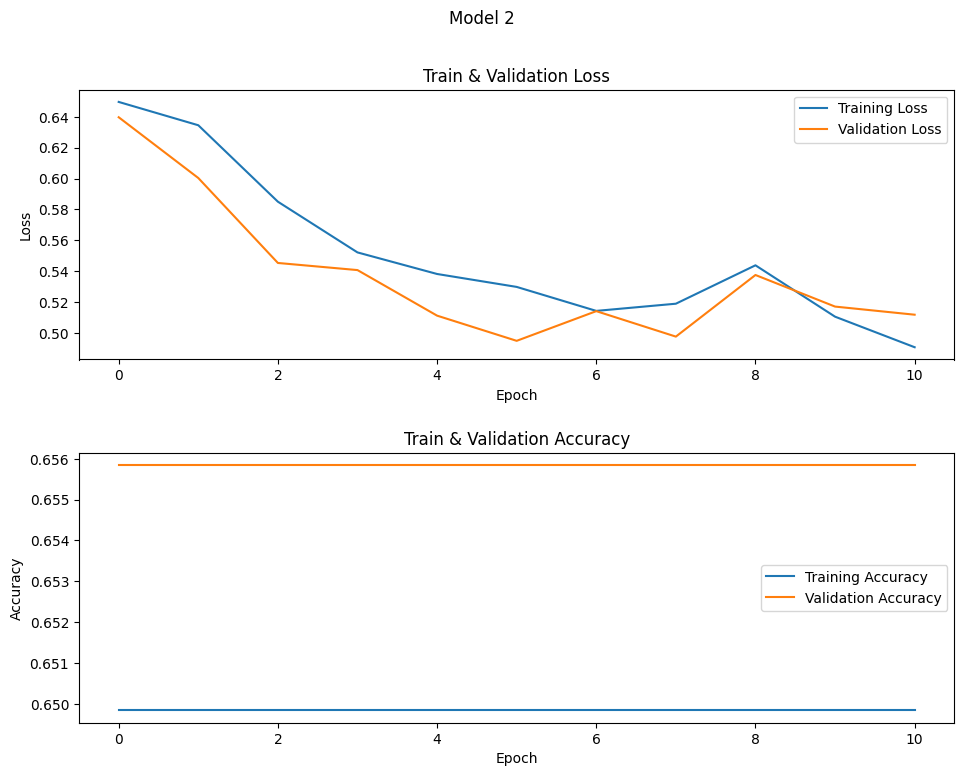

              precision    recall  f1-score   support

Non-diabetic       0.66      1.00      0.79       101
    Diabetic       0.00      0.00      0.00        53

    accuracy                           0.66       154
   macro avg       0.33      0.50      0.40       154
weighted avg       0.43      0.66      0.52       154

accuracy on the model was 65.58441558441558%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


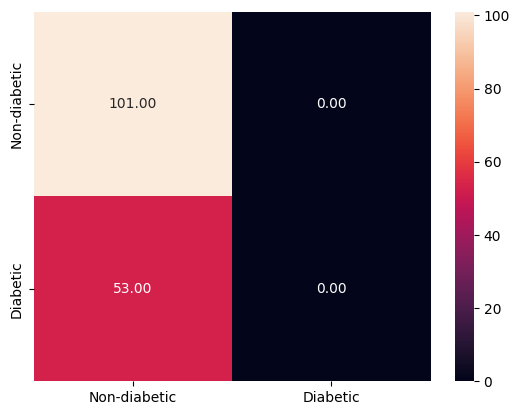

In [42]:
#model2
evalFunction(model2, loaderNormal, epochLog2, trainAccLog2, trainLossLog2, validationAccLog2, validationLossLog2, 'Model 2')

<Figure size 1000x800 with 0 Axes>

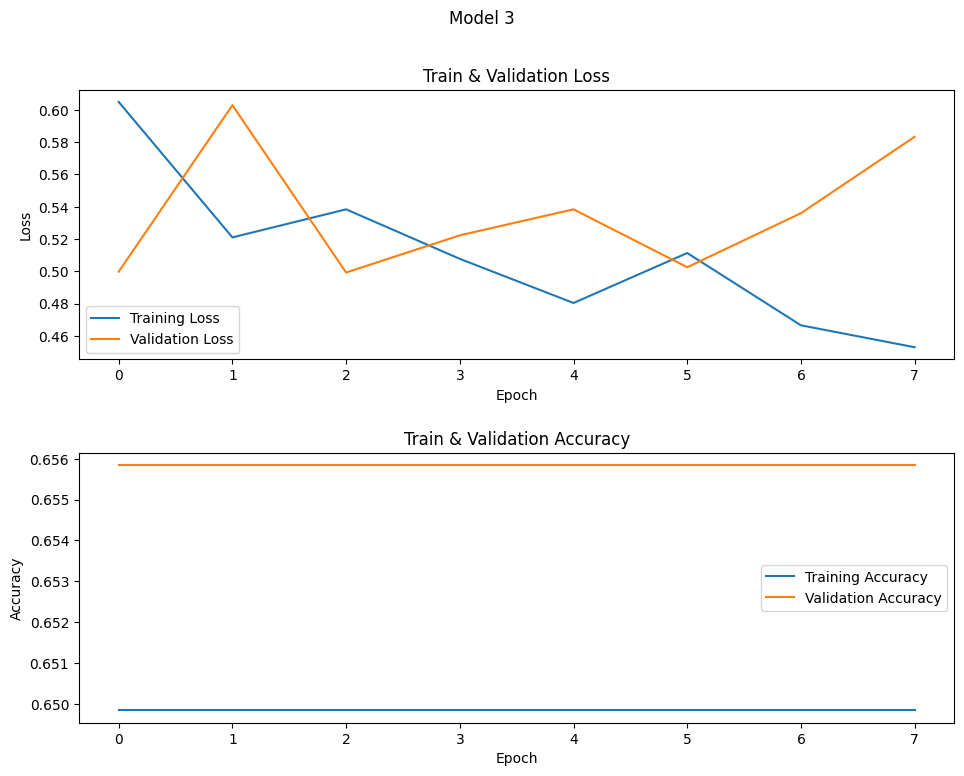

              precision    recall  f1-score   support

Non-diabetic       0.66      1.00      0.79       101
    Diabetic       0.00      0.00      0.00        53

    accuracy                           0.66       154
   macro avg       0.33      0.50      0.40       154
weighted avg       0.43      0.66      0.52       154

accuracy on the model was 65.58441558441558%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


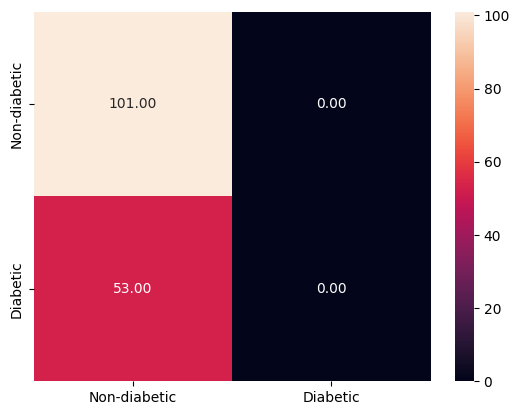

In [43]:
#model3
evalFunction(model3, loaderNormal, epochLog3, trainAccLog3, trainLossLog3, validationAccLog3, validationLossLog3, 'Model 3')

<Figure size 1000x800 with 0 Axes>

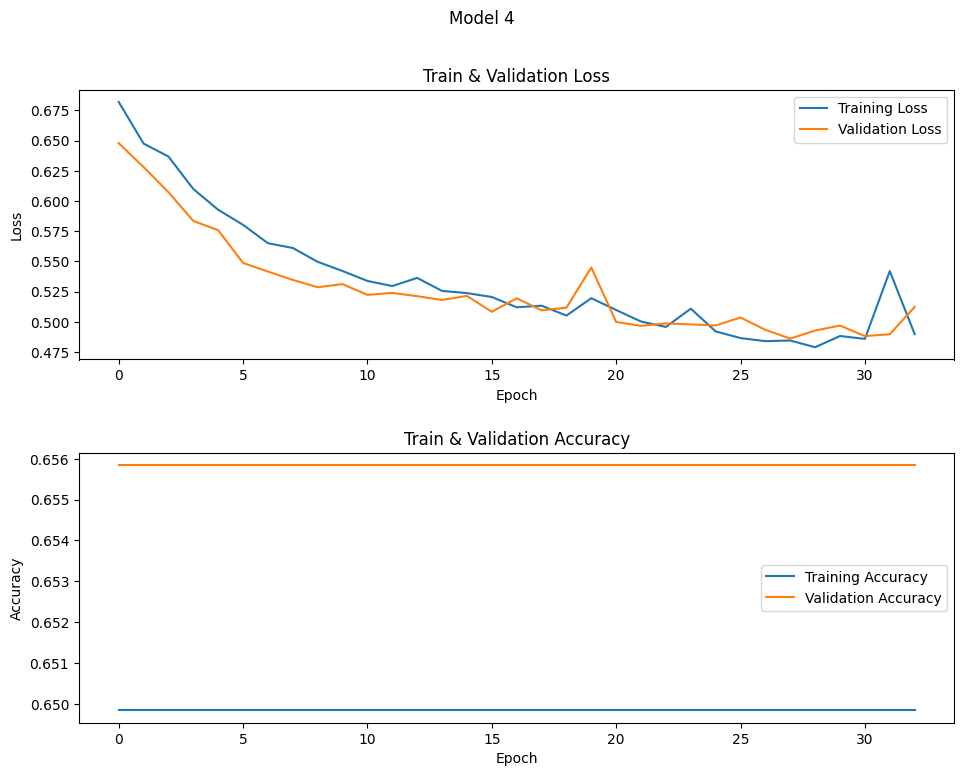

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

Non-diabetic       0.66      1.00      0.79       101
    Diabetic       0.00      0.00      0.00        53

    accuracy                           0.66       154
   macro avg       0.33      0.50      0.40       154
weighted avg       0.43      0.66      0.52       154

accuracy on the model was 65.58441558441558%


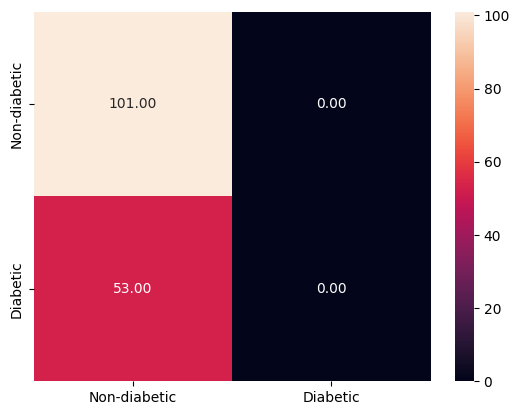

In [44]:
#model4
evalFunction(model4, loaderNormal, epochLog4, trainAccLog4, trainLossLog4, validationAccLog4, validationLossLog4, 'Model 4')

## Evaluation high corr cols

<Figure size 1000x800 with 0 Axes>

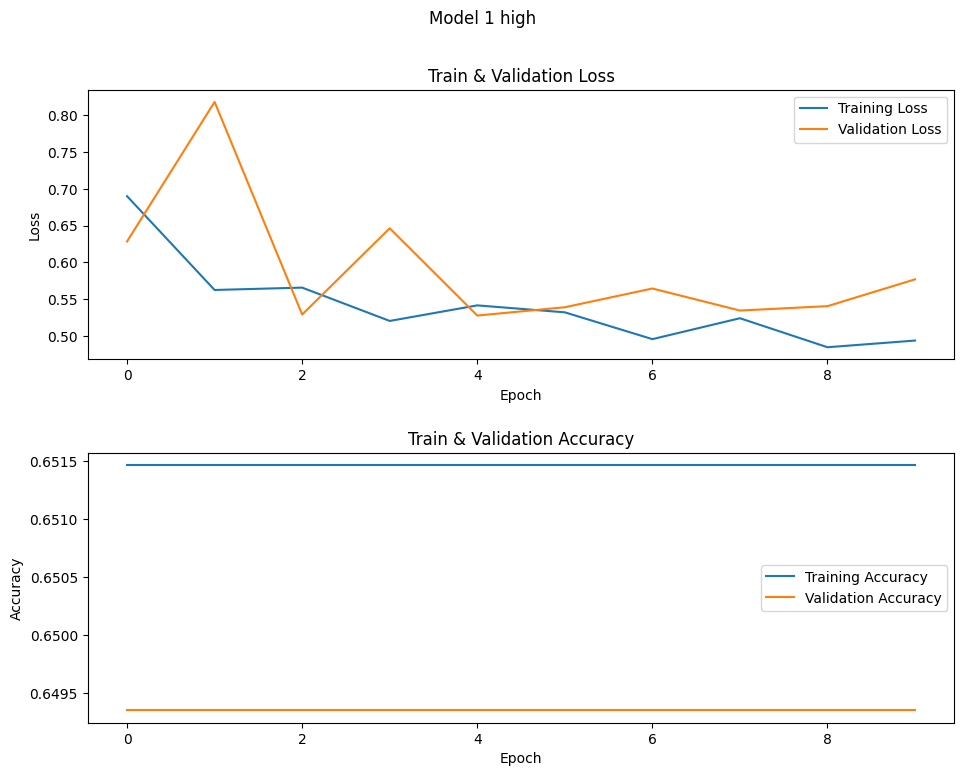

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

Non-diabetic       0.65      1.00      0.79       100
    Diabetic       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154

accuracy on the model was 64.93506493506493%


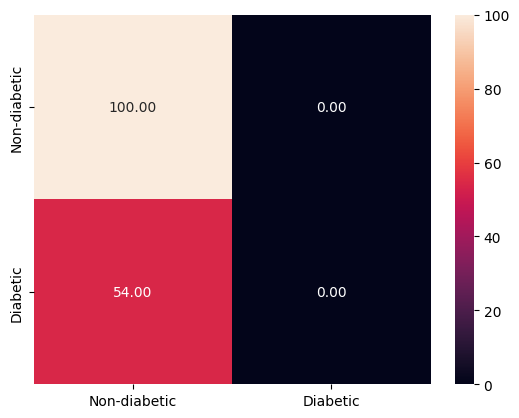

In [45]:
#model1high
evalFunction(model1high, loaderHigh, highEpochLog1, highTrainAccLog1, highTrainLossLog1, highValidationAccLog1, highValidationLossLog1, 'Model 1 high')

<Figure size 1000x800 with 0 Axes>

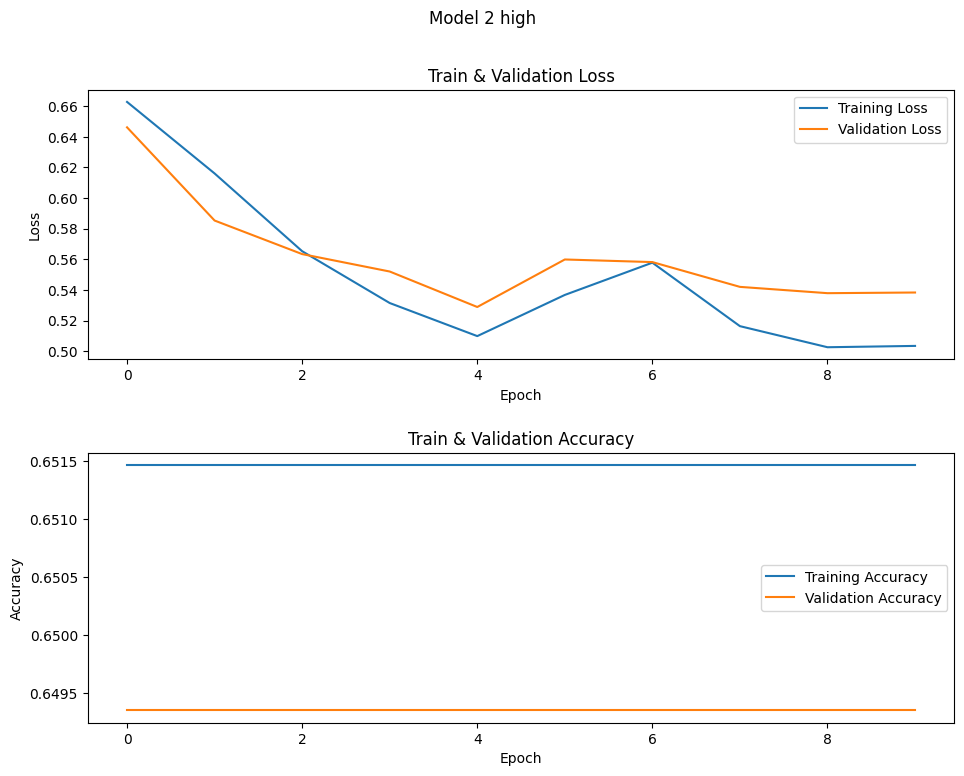

              precision    recall  f1-score   support

Non-diabetic       0.65      1.00      0.79       100
    Diabetic       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154

accuracy on the model was 64.93506493506493%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


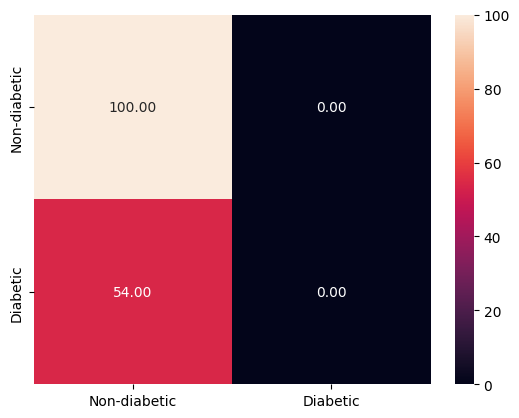

In [46]:
#model2high
evalFunction(model2high, loaderHigh, highEpochLog2, highTrainAccLog2, highTrainLossLog2, highValidationAccLog2, highValidationLossLog2, 'Model 2 high')

<Figure size 1000x800 with 0 Axes>

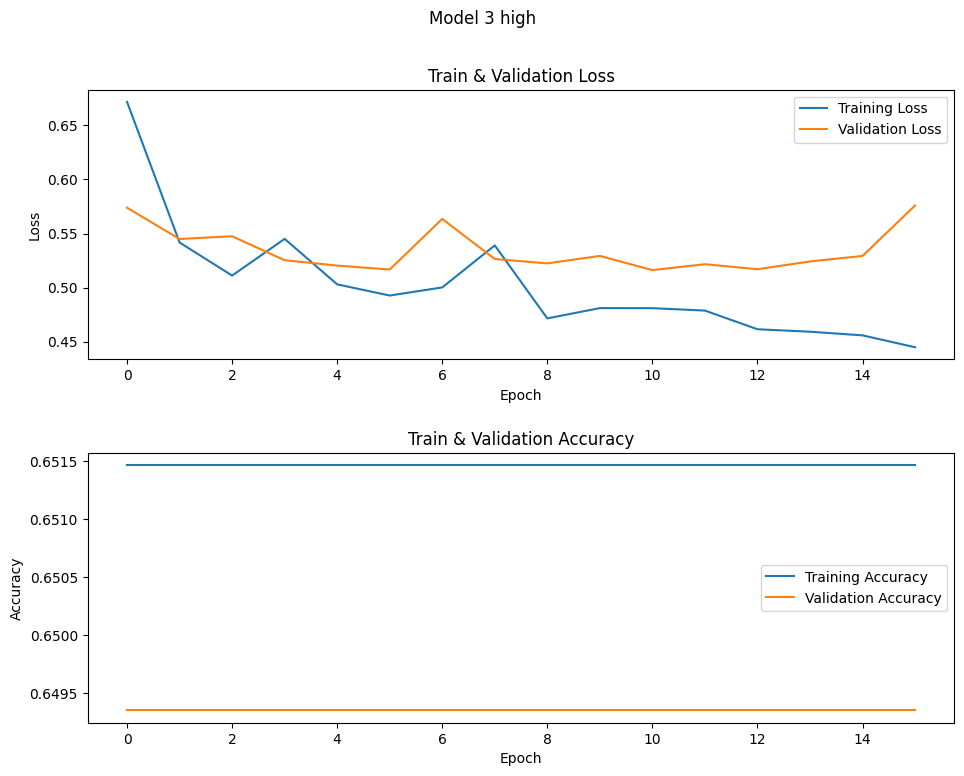

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

Non-diabetic       0.65      1.00      0.79       100
    Diabetic       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154

accuracy on the model was 64.93506493506493%


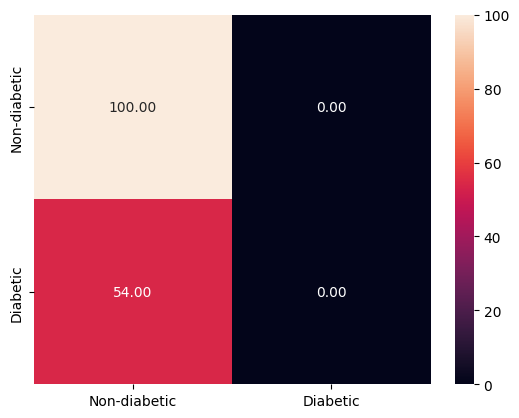

In [47]:
#model3high
evalFunction(model3high, loaderHigh, highEpochLog3, highTrainAccLog3, highTrainLossLog3, highValidationAccLog3, highValidationLossLog3, 'Model 3 high')

<Figure size 1000x800 with 0 Axes>

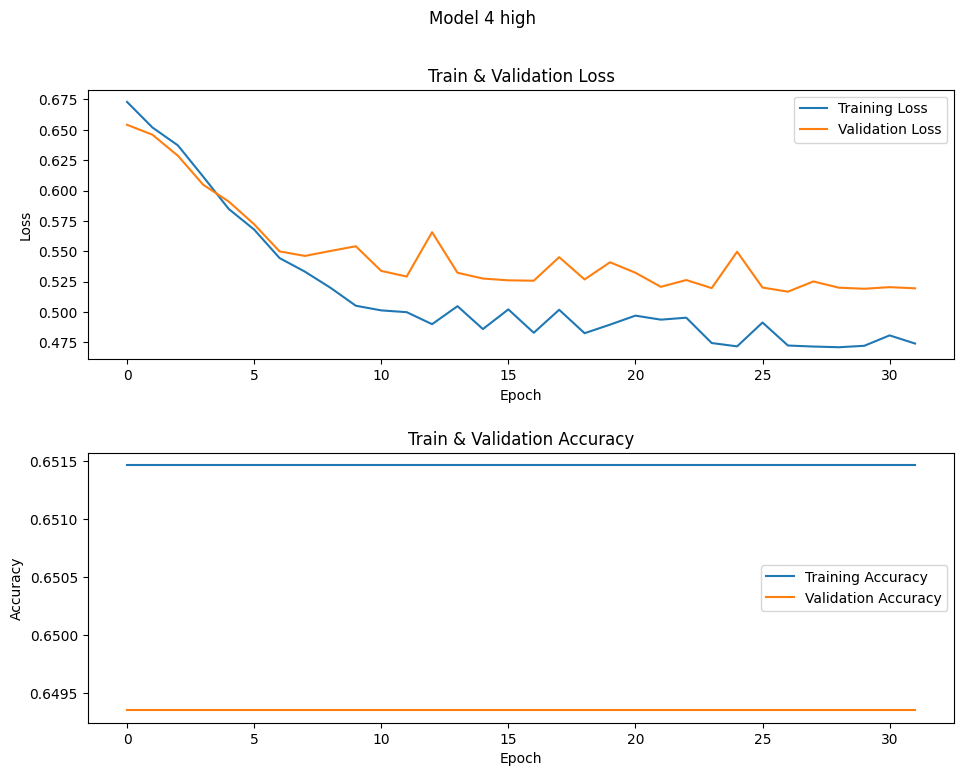

              precision    recall  f1-score   support

Non-diabetic       0.65      1.00      0.79       100
    Diabetic       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154

accuracy on the model was 64.93506493506493%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


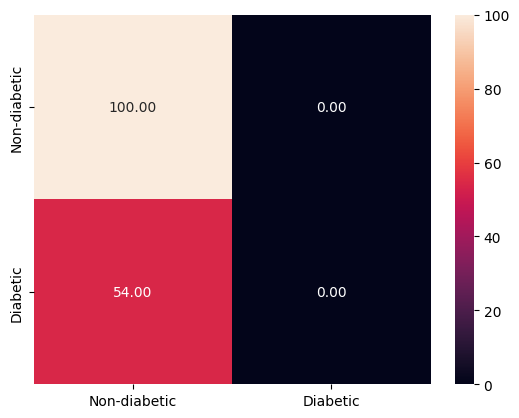

In [48]:
#model4high
evalFunction(model4high, loaderHigh, highEpochLog4, highTrainAccLog4, highTrainLossLog4, highValidationAccLog4, highValidationLossLog4, 'Model 4 high')

## Best Model